# Warning Model: Predicting FAO Food Security Warnings

Utilizing the predictive power for food commodity price of the model developed in `model_experiments.ipynb`, we will now predict when the FAO will issue a food security warning for specific countries. To do this, we have scraped the FAO's food security warnings from their website from 2014-2024 and will use the model to predict when the next warning will be issued for each country.




In [1]:
# External Data Manipulation Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Machine Learning Packages
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

# Internal Python Packages
import os
import ast

In [2]:
TEST_SIZE = 0.2

## Part 1: Preparing the Data for ML Prediction
Most of the work has already been done in `data_analysis.ipynb` in section `Part 3.5b: Format the Pulled Data for Input Into ML For Training`

In [3]:
warning_data = pd.read_csv('model_data/warning_prediction_model_data.csv')
warning_data

,input,output
0,"[0.6751068578065273, 0.2035026414116691, 0.272...",0
1,"[0.4249449091480846, 0.3328979784230554, 0.350...",0
2,"[0.423015477057872, 0.2951778165596092, 0.3099...",0
3,"[0.4209903004429556, 0.2465320932498714, 0.293...",0
4,"[0.4184325684602384, 0.2403253619786105, 0.289...",0
...,...,...
414,"[0.6782421083541244, 0.5880788425995347, 0.458...",0
415,"[0.6560355345573108, 0.6230934661080839, 0.439...",0
416,"[0.6340369525417867, 0.6395070782470962, 0.463...",0
417,"[0.6107742945217218, 0.6549491237528886, 0.473...",0


In [4]:
# # Create augmented warning data
# import random

# def generate_dataset(num_entries, input_size):
#     dataset = []
#     for _ in range(num_entries):
#         input_list = [random.random() for _ in range(input_size)]
#         output = random.randint(0, 2)
#         dataset.append((input_list, output))
#     return dataset

# # Example usage:
# dataset = generate_dataset(1000, len(ast.literal_eval(warning_data['input'][0])))  # Generate 100 entries with 10 inputs each

# # Given this new dataset, add it to warning_data (use concat)
# new_input = [list(x[0]) for x in dataset]
# new_output = [x[1] for x in dataset]
# new_data = pd.DataFrame({'input': new_input, 'output': new_output})
# warning_data = pd.concat([warning_data, new_data], ignore_index=True)

# # Ensure all inputs are of type 'str'
# warning_data['input'] = warning_data['input'].apply(lambda x: str(x))

# warning_data

In [5]:
# Make each row of the 'input' column a list instead of a string
warning_data['input'] = warning_data['input'].apply(ast.literal_eval)

num_input_samples = len(warning_data['input'][0])
num_input_samples

10

In [6]:
# Change the output column to be categorical (0: [1, 0, 0], 1: [0, 1, 0], 2: [0, 0, 1])
warning_data['output'] = warning_data['output'].apply(lambda x: [1, 0, 0] if x == 0 else [0, 1, 0] if x == 1 else [0, 0, 1])

In [7]:
def format_for_ML_usage(inputs, outputs):
    """
    Given the inputs and outputs for the model, format the data to be used for ML.
    This is accomplished by splitting the data into training/test tensors
    :param inputs: inputs for the model (list of lists)
    :param output: output for the model (list of values)

    :return: The tensors responsible for testing/training the model and the scaler used to scale the data
            (x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, scaler)
    """
    inputs = inputs.tolist()
    outputs = outputs.tolist()

    # Create a train/test split for the dataset
    x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=TEST_SIZE, shuffle=True, random_state=42)

    # Determine if there are any nan values in x_train
    for i in range(len(x_train)):
        if np.isnan(x_train[i]).any():
            print(f'x_train[{i}] has nan values! Check the data!')

    # Convert them all to numpy arrays
    x_train = np.array(x_train).reshape(-1, num_input_samples)
    x_test = np.array(x_test).reshape(-1, num_input_samples)
    y_train = np.array(y_train).reshape(-1, 3) # required reshape for StandardScaler
    y_test = np.array(y_test).reshape(-1, 3) # required reshape for StandardScaler

    # Standardize/Normalize the dataset
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train).reshape(-1, num_input_samples, 1)
    x_test_scaled = scaler.transform(x_test).reshape(-1, num_input_samples, 1)

    # Convert to tensors for model ingestion (true training data)
    x_train_tensor = tf.convert_to_tensor(x_train_scaled)
    x_test_tensor = tf.convert_to_tensor(x_test_scaled)
    y_train_tensor = tf.convert_to_tensor(y_train)
    y_test_tensor = tf.convert_to_tensor(y_test)

    return (x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, scaler)

In [8]:
warning_data['output']

0      [1, 0, 0]
1      [1, 0, 0]
2      [1, 0, 0]
3      [1, 0, 0]
4      [1, 0, 0]
         ...    
414    [1, 0, 0]
415    [1, 0, 0]
416    [1, 0, 0]
417    [1, 0, 0]
418    [1, 0, 0]
Name: output, Length: 419, dtype: object

In [9]:
x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, scaler = format_for_ML_usage(warning_data['input'], warning_data['output'])
print('x_train_tensor shape:', x_train_tensor.shape)
print('x_test_tensor shape:', x_test_tensor.shape)
print('y_train_tensor shape:', y_train_tensor.shape)
print('y_test_tensor shape:', y_test_tensor.shape)

x_train_tensor shape: (335, 10, 1)
x_test_tensor shape: (84, 10, 1)
y_train_tensor shape: (335, 3)
y_test_tensor shape: (84, 3)


## Part 2: Defining a Model To Predict Warnings

In [10]:
# Model Architecture
HEAD_SIZE = 64
NUM_HEADS = 16
FF_DIM = 512

# ML Optimizer
LEARNING_RATE = 1e-5
CLIP_VALUE = 0.5 # Gradient Clipping (https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem)
DROP_OUT_RATE = 0.1
L1 = 0.000 # L1 Regularization Value
L2 = 0.002 # L2 Regularization Value
d_model = x_train_tensor.shape[-1] 
length = x_train_tensor.shape[1]  

In [11]:
# Define positional encoding function (another portion for data preprocessing)
def positional_encoding(length, depth):
    """ 
    Create positional encoding
    args:
        length: length of the sequence
        depth: depth of the model
    """
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / depth) for j in range(depth)]
        for pos in range(length)
    ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])
    return tf.cast(pos_enc, dtype=tf.float32)

In [12]:
def transformer(head_size, num_heads, ff_dim, dropout=0, num_transformers=50):
    """
    Building a simple transformer based off the original work compiled in
    the research paper "Attention Is All You Need" (https://arxiv.org/pdf/1706.03762.pdf)
    :param int head_size: Size of the attention heads
    :param int num_heads: Number of heads
    :param int ff_dim: Feed forward dimension
    :param float dropout: Dropout rate
    """
    
    # Input Layer
    inputs = tf.keras.layers.Input(shape=(num_input_samples, d_model)) # (None, 9, 1)

    # Add positional encoding to the input
    # The positional encoding is added to the input in order to give the model some information about the relative position of the words in the sequence
    # Not including the positional encoding is basically the same as randomizing the order of the data
    positional_inputs = inputs + positional_encoding(num_input_samples, d_model) # (None, 9, 1)
    
    # Multi-Head Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(positional_inputs) # (None, 9, 1)
     
    for i in range(num_transformers):
        # print("At start of transformer ", i, " x shape: ", x.shape)
        x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x) # (None, 9, 1)
        x = tf.keras.layers.Dropout(dropout)(x) # (None, 9, 1)
        
        # Add & Norm
        res = x + positional_inputs # (None, 9, 1)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res) # (None, 9, 1)
        
        # Feed-Forward Network (Using Dense layers instead of Conv1D layers)
        x = tf.keras.layers.Dense(ff_dim, activation='relu', kernel_regularizer=regularizers.L1L2(L1, L2))(x) # (None, 9, ff_dim)
        x = tf.keras.layers.Dense(ff_dim//2, activation='relu', kernel_regularizer=regularizers.L1L2(L1, L2))(x) # (None, 9, ff_dim//2)
        x = tf.keras.layers.Dense(ff_dim//4, activation='relu', kernel_regularizer=regularizers.L1L2(L1, L2))(x) # (None, 9, ff_dim//4)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout)(x) # (None, 9, ff_dim//4)

        # Get the shape of x back to (None, 9, 1)
        x = tf.keras.layers.Dense(d_model)(x)
        
        # Skip Connection     
        x = x + res # (None, 9, 1)
        # print("At end of transformer ", i, " x shape: ", x.shape)

    # Global Average Pooling layer
    # The Global Average Pooling layer reduces the dimensionality/complexity of the data
    x = tf.keras.layers.GlobalAveragePooling1D()(x) # (None, 16)
    
    # Output Layer (WARNING: Don't use sigmoid, requires too high of gradient to achieve ~1 or ~0)
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x) # (None, 3)

    return inputs, outputs

In [13]:
# Get the count of the unique elements in the y_train
unique, counts = np.unique(np.argmax(y_train_tensor, axis=1), return_counts=True)
print('Unique elements in y_train:', unique)
print('Counts of unique elements in y_train:', counts)

Unique elements in y_train: [0 1 2]
Counts of unique elements in y_train: [305  18  12]


In [14]:
inputs,outputs = transformer(HEAD_SIZE, NUM_HEADS, FF_DIM, dropout = DROP_OUT_RATE)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Convert one-hot encoded labels to integer labels for computing class weights
y_integers = np.argmax(y_train_tensor[:-1, :], axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
class_weights_dict = dict(enumerate(class_weights))

# Ensure all the weights are reset
tf.keras.backend.clear_session()

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 1)]              0         []                            
                                                                                                  
 tf.__operators__.add (TFOp  (None, 10, 1)                0         ['input_1[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 layer_normalization (Layer  (None, 10, 1)                2         ['tf.__operators__.add[0][0]']
 Normalization)                                                                                   
                                                                                              

## Part 3: Training a Model To Predict Warnings

In [15]:
def learning_rate_scheduler(epoch, lr):
    """
    Learning rate scheduler
    :param int epoch: current epoch
    :param float lr: current learning rate
    """
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callback = LearningRateScheduler(learning_rate_scheduler)

In [16]:
NUM_EPOCHS = 40
BATCH_SIZE = 3 # Fiscal Quarters

In [17]:
print('x_train_tensor shape:', x_train_tensor.shape)
print('y_train_tensor shape:', y_train_tensor.shape)


x_train_tensor shape: (335, 10, 1)
y_train_tensor shape: (335, 3)


In [18]:
history = model.fit(
    x_train_tensor[:-1, :], y_train_tensor[:-1, :],
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[callback],
    class_weight=class_weights_dict  # Apply class weights here
)

Epoch 1/40


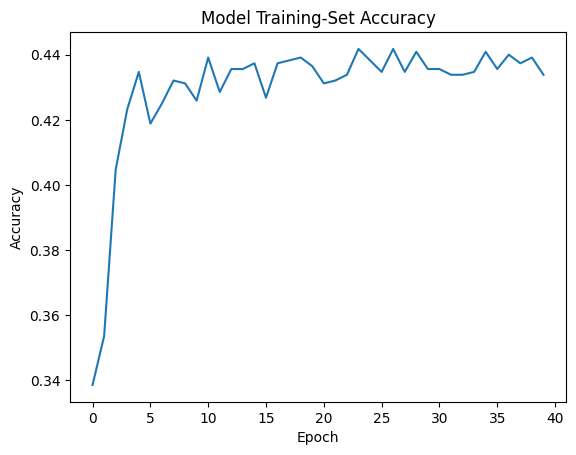

In [ ]:
# Plot the accuracy over time
plt.plot(history.history['accuracy'])
plt.title('Model Training-Set Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

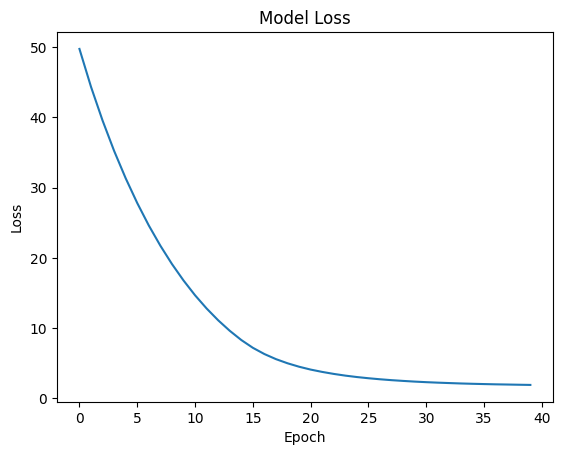

In [ ]:
# Plot the loss over time
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Part 4: Visualizing the Model Understanding

In [ ]:
# Raw Accuracy (does not account for class imabalance)
test_loss, test_accuracy = model.evaluate(x_test_tensor, y_test_tensor)
print(f"Testing accuracy: {test_accuracy}")

9/9 [==============================] - 21s 940ms/step - loss: 1.8841 - accuracy: 0.4401
Testing accuracy: 0.44014084339141846


In [ ]:
# F1 Score (accounts for class imbalance)
y_pred = model.predict(x_test_tensor)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_tensor, axis=1)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")

9/9 [==============================] - 19s 920ms/step
F1 Score: 0.395704969776375


In [ ]:
# Save the model
model.save(f'saved_models/warning_prediction/warning_model_f1{f1}.h5')

c:\Users\paulsonb\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the previous model and get its predictions on the entire testing dataset
loaded_model = tf.keras.models.load_model('saved_models/warning_prediction/warning_model_f10.721834112841158.h5')
y_pred = loaded_model.predict(x_test_tensor)

3/3 [==============================] - 10s 320ms/step


In [ ]:
warnings = pd.read_csv('all_data/15-16_warnings_data.csv')
warnings

,country,commodity,warning_level (1=moderate; 2=high),month,year,growth_rate_3,growth_rate_12
0,Argentina,Wheat Flour,2,12,2023,9.8,5.1
1,Myanmar,Rice,2,1,2024,9.8,4.2
2,Nigeria,Staple Foods,2,9,2023,na,na
3,Pakistan,Wheat Flour,2,1,2024,na,na
4,South Sudan,Staple Foods,2,1,2024,7.1,3.1
...,...,...,...,...,...,...,...
1000,Nicaragua,Maize,1,11,2015,-8.7,3
1001,South Africa,Maize,2,11,2015,4.6,3.3
1002,Uganda,Maize,2,11,2015,12.9,6
1003,United Republic of Tanzania,Maize,2,11,2015,1.6,7.5


In [ ]:
# From the inputs of the x_test_tensor, determine what rows from the warnings_data that test data came from
# This will allow us to compare the predictions to the actual values

# Un-scaler the x_test_tensor
x_test_unscaled = scaler.inverse_transform(x_test_tensor.numpy().reshape(-1, num_input_samples)).reshape(-1, num_input_samples)

# Convert the x_test_tensor to a dataframe
x_test_df = pd.DataFrame(x_test_unscaled.reshape(-1, num_input_samples))

# Rename the numerical columns to this: 
column_names = ['Proteus2', 'Food Price Index', 'Cereals Price Index', 'Wheat Futures',
       'Harvest', 'Sentiment', 'price_1', 'price_2', 'price_3',
       'Price Prediction']
x_test_df.columns = column_names

# Make a model prediction for each row
y_pred = loaded_model.predict(x_test_tensor)
y_pred = np.argmax(y_pred, axis=1)
x_test_df['Model Prediction'] = y_pred

x_test_df

3/3 [==============================] - 1s 169ms/step


,Proteus2,Food Price Index,Cereals Price Index,Wheat Futures,Harvest,Sentiment,price_1,price_2,price_3,Price Prediction,Model Prediction
0,0.109148,0.292954,0.329330,0.358422,0.496882,-1.0,0.157558,0.141869,0.118924,0.096719,0
1,0.405191,0.182952,0.242191,0.243797,0.771551,-1.0,0.226521,0.251425,0.260590,0.163415,0
2,0.978267,0.246532,0.293765,0.242949,0.072122,-1.0,0.199142,0.192282,0.193983,0.154278,0
3,0.667111,0.580207,0.440749,0.498133,0.152912,1.0,0.407004,0.470270,0.549483,0.524357,2
4,0.075509,0.197033,0.234792,0.198229,0.534390,-1.0,0.111371,0.101402,0.127281,0.048141,0
...,...,...,...,...,...,...,...,...,...,...,...
79,0.816835,0.244981,0.323526,0.296808,0.761752,1.0,0.303419,0.287776,0.304131,0.473243,2
80,0.340644,0.199032,0.287738,0.388673,0.429946,1.0,0.344922,0.356754,0.373643,0.499552,2
81,0.091548,0.278475,0.319188,0.288799,0.575917,-1.0,0.150457,0.111371,0.101402,0.086944,0
82,0.412150,0.669423,0.490892,0.661989,0.433959,1.0,0.621298,0.680578,0.738961,0.798527,2


In [ ]:
x_test_df.to_csv('warning_results_from_predictions.csv', index=False)